In [39]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.base import clone
import os
from datetime import datetime
from sklearn import metrics
from math import sqrt
import time
from IPython.display import display, Javascript
import hashlib
from sklearn.utils import resample
from sklearn.metrics import make_scorer

In [40]:
# seed results

s = 2017
np.random.seed(s)

In [41]:
# CONTROLS

#model = LogisticRegression(max_iter=10000)
#model = RandomForestClassifier()
model = xgb.XGBClassifier(eval_metric='error', use_label_encoder=False)

#missingness_threshold = 0.9
missingness_threshold = 0.75
#missingness_threshold = 0.5
#missingness_threshold = 0.25

#outcome = 'alc_postlt'
outcome = 'harmfuldrink'

#imputation_strategy = '-1'
#imputation_strategy = 'mode'
imputation_strategy = None # only for XGBoost

# sklearn metrics: https://scikit-learn.org/stable/modules/model_evaluation.html
#optimization_metric = 'accuracy'
#optimization_metric = 'precision'
#optimization_metric = 'recall'
optimization_metric = 'roc_auc'

#patient_questions_only = True
patient_questions_only = False

include_feature_selection = True
#include_feature_selection = False

#include_upsampling = True
include_upsampling = False

#validation_centers = ['rand', 0.2, 'drop'] # choose from: 1-12 inclusive or ['rand', x, 'one-hot' or 'drop']
#validation_centers = ['rand', 0.2, 'one-hot'] # choose from: 1-12 inclusive or ['rand', x, 'one-hot' or 'drop']
#validation_centers = [] # choose from: 1-12 inclusive or ['rand', x, 'one-hot' or 'drop']
validation_centers = [8,9] # choose from: 1-12 inclusive or ['rand', x, 'one-hot' or 'drop']
#validation_centers = [9,11] # choose from: 1-12 inclusive or ['rand', x, 'one-hot' or 'drop']

## Data Pre-Processing

In [42]:
df = pd.read_stata('./data/psychosocial_data.dta') # read in questions
print(df.shape)
df.head()

(205, 1721)


id  nid  q1  q2  q3  q4  q5  q6  q7  q8  q9  q10  q11  q12  q13  q14  q15  \
0   1   47   7   2   1   1   1   0   0   0   0    1  NaN  NaN    1  1.0  1.0   
1   2   48   7   2   1   1   1   0   0   0   0    1  NaN  NaN    2  NaN  0.0   
2   3   49   5   2   0   1   1   0   0   0   0    1  NaN  NaN    1  NaN  0.0   
3   4   81   8   2   1   0   1   0   0   0   0    1  NaN  NaN    2  1.0  1.0   
4   5   82  13   2   1   1   1   0   0   0   1    1  NaN  NaN    2  1.0  0.0   

   q16  q17  q18  q19  q20  q21  q22  q23  q24  q25  q26  q27  q28  q29  q30  \
0  NaN  NaN  NaN  NaN  NaN  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   
1  2.0  NaN  NaN  NaN  NaN  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   
2  2.0  NaN  NaN  NaN  0.0  0.0    0  NaN  NaN  0.0    0  NaN    2  NaN  NaN   
3  2.0  NaN  NaN  NaN  0.0  0.0    0  1.0  NaN  0.0    0  NaN    2  NaN  NaN   
4  2.0  NaN  NaN  NaN  0.0  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   

   q31  q32  q33  q34  q35  q36  q37  q38  q39  q40  q41  q42  q43  q44  q45  \
0  NaN  NaN    0  NaN  0.0  NaN  3.0  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN   
1  NaN  NaN    0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN   
2  0.0  NaN    0  NaN  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  NaN  NaN    0  NaN  0.0  0.0  2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN    0  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  0.0  NaN   

   q46  q47  q48  q49  q50  q51  q52  q53  q54  q55  q56  q57  q58  q59  q60  \
0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  1.0  NaN   
1  NaN  0.0  0.0  0.0  0.0  1.0  NaN  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN   
2  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  0.0  NaN  NaN  NaN   
3  1.0  NaN  0.0  0.0  NaN  0.0  0.0  0.0  0.0  NaN  NaN  NaN  0.0  0.0  NaN   
4  1.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   q61  q62  q63  q64  q65  q66  q67  q68  q69  q70  q71  q72   q73  q74  q75  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0    0    0  NaN  36.0  8.0  8.0   
1  NaN  1.0  NaN  NaN  NaN  NaN  NaN  1.0    0    0    0  NaN  60.0  NaN  2.0   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0    0    0  NaN   NaN  7.0  8.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0    1    0    2  NaN   NaN  NaN  NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0    0    0  NaN   NaN  NaN  NaN   

   q76  q77  q78  q79   q80  q81  q82  q83  q84  q85  q86  q87  q88  q89  q90  \
0  0.0  0.0  1.0  NaN   NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  30.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  0.0  0.0  1.0  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  NaN  NaN  NaN  NaN   0.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN  NaN  3.0  18.0  1.0  1.0  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN   

   q91  q92  q93  q94  q95  q96  q97  q98  q99  q100  q101  q102  q103  q104  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   1.0   NaN   NaN   
4  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN   NaN   NaN   1.0   NaN  12.0   

   q105  q106  q107  q108  q109  q110  q111  q112  q113  q114  q115  q116  \
0   NaN   NaN   0.0   0.0   0.0   0.0   NaN   0.0   0.0   NaN   0.0   0.0   
1   NaN   NaN   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   NaN   NaN   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   NaN   NaN   0.0   0.0   0.0   0.0   0.0   NaN   1.0   NaN   1.0   0.0   
4   NaN   2.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   

   q117  q118  q119  q120  q121  q122  q123  q124  q125  q126  q127  q128  \
0   0.0   NaN   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   0.0

In [43]:
question_data = df.filter(regex='^q[0-9]{1,3}$',axis=1) # filter to columns containing the 199 questions asked
question_data = pd.concat([question_data, df[['id', 'nid']]], axis=1) # keep id and nid columns
question_data.shape

(205, 201)

In [44]:
# drop correlated & irrelevant rows based on Brian/Norah's input
corr_cols = ['q32','q91','q96','q99','q118','q119','q122','q124','q143','q156','q159','q166','q176','q187']
irr_cols = ['q1','q3','q4','q10','q18','q19','q22','q141','q198']
question_data.drop(inplace=True, columns=corr_cols+irr_cols) # remove merging variables
question_data.shape

(205, 178)

In [45]:
# recode categorical variables based on Brian/Norah's input

question_data['q12'] = question_data['q12'].replace(to_replace={3:2})

question_data['q13'] = question_data['q13'] + 10
question_data['q13'] = question_data['q13'].replace(to_replace={10:0, 11:1, 12:1, 13:2, 14:2})

question_data['q21'] = question_data['q21'] + 10
question_data['q21'] = question_data['q21'].replace(to_replace={10:0, 11:1, 12:1, 13:2})

question_data['q128'] = question_data['q128'] + 10
question_data['q128'] = question_data['q128'].replace(to_replace={10:0, 11:1, 12:1, 13:1, 14:2, 15:2, 16:2})

question_data['q160'] = question_data['q160'] + 10
question_data['q160'] = question_data['q160'].replace(to_replace={10:0, 11:1, 12:1, 13:2})

question_data['q190'] = question_data['q190'] + 10
question_data['q190'] = question_data['q190'].replace(to_replace={10:0, 11:1, 12:1, 13:1, 14:1, 15:1, 16:2, 17:2})

In [46]:
non_patient_questions = ['q1','q2','q3','q4','q5','q6','q7','q8','q9','q10','q12','q22',
                         'q33','q71','q129','q130','q145','q198']
mixed_questions = ['q28','q70','q146'] # 0 and NaN mean missing value
special_mixed_questions = ['q27','q40'] # only NaN means missing value

if patient_questions_only:
    question_data.drop(columns=non_patient_questions+mixed_questions+special_mixed_questions, inplace=True)
else: # split mixed questions
    def mixed_question_splitter(row, q): # return 1 if question has non-zero and non-null value
        if np.isnan(row[q]) or row[q] == 0:
            return 0
        return 1
    
    for q in mixed_questions: 
        new_label = q + '_split'
        question_data[new_label] = df.apply(lambda row: mixed_question_splitter(row, q), axis=1)
        
    def special_mixed_question_splitter(row, q): # return 1 if question has only non-null value
        if np.isnan(row[q]):
            return 0
        return 1
        
    for q in special_mixed_questions: 
        new_label = q + '_split'
        question_data[new_label] = df.apply(lambda row: special_mixed_question_splitter(row, q), axis=1)
    
print(question_data.shape)
question_data.head() # make sure splitting/dropping happened correctly

(205, 183)


,q2,q5,q6,q7,q8,q9,q11,q12,q13,q14,q15,q16,q17,q20,q21,q23,q24,q25,q26,q27,q28,q29,q30,q31,q33,q34,q35,q36,q37,q38,q39,q40,q41,q42,q43,q44,q45,q46,q47,q48,q49,q50,q51,q52,q53,q54,q55,q56,q57,q58,q59,q60,q61,q62,q63,q64,q65,q66,q67,q68,q69,q70,q71,q72,q73,q74,q75,q76,q77,q78,q79,q80,q81,q82,q83,q84,q85,q86,q87,q88,q89,q90,q92,q93,q94,q95,q97,q98,q100,q101,q102,q103,q104,q105,q106,q107,q108,q109,q110,q111,q112,q113,q114,q115,q116,q117,q120,q121,q123,q125,q126,q127,q128,q129,q130,q131,q132,q133,q134,q135,q136,q137,q138,q139,q140,q142,q144,q145,q146,q147,q148,q149,q150,q151,q152,q153,q154,q155,q157,q158,q160,q161,q162,q163,q164,q165,q167,q168,q169,q170,q171,q172,q173,q174,q175,q177,q178,q179,q180,q181,q182,q183,q184,q185,q186,q188,q189,q190,q191,q192,q193,q194,q195,q196,q197,q199,id,nid,q28_split,q70_split,q146_split,q27_split,q40_split
0,2,1,0,0,0,0,NaN,NaN,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,0,NaN,NaN,NaN,0,NaN,0.0,NaN,3.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,36.0,8.0,8.0,0.0,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,0,1,4.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,NaN,2.0,0,1,47,0,0,1,0,0
1,2,1,0,0,0,0,NaN,NaN,1,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0,0,0,NaN,60.0,NaN,2.0,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,0,NaN,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,0,0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1,1.0,NaN,NaN,1.0,NaN,NaN,NaN,0,2,48,0,0,0,0,0
2,2,1,0,0,0,0,NaN,NaN,1,NaN,0.0,2.0,NaN,0.0,0.0,NaN,NaN,0.0,0,NaN,2,NaN,NaN,0.0,0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,7.0,8.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,0.0,NaN,1.0,1.0,NaN,1.0,NaN,2.0,NaN,0,0,5.0,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0,NaN,0.0,NaN,0.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,NaN,NaN,0,3,49,1,0,0,0,0
3,2,1,0,0,0,0,NaN,NaN,1,1.0,1.0,2.0,NaN,0.0,0.0,1.0,NaN,0.0,0,NaN,2,NaN,NaN,NaN,0,NaN,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,2.0,NaN,1,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1,1.0,NaN,NaN,1.0,NaN,NaN,NaN,0,4,81,1,0,0,0,0
4,2,1,0,0,0,1,NaN,NaN,1,1.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN,0.0,0,NaN,0,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,18.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,12.0,NaN,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Na

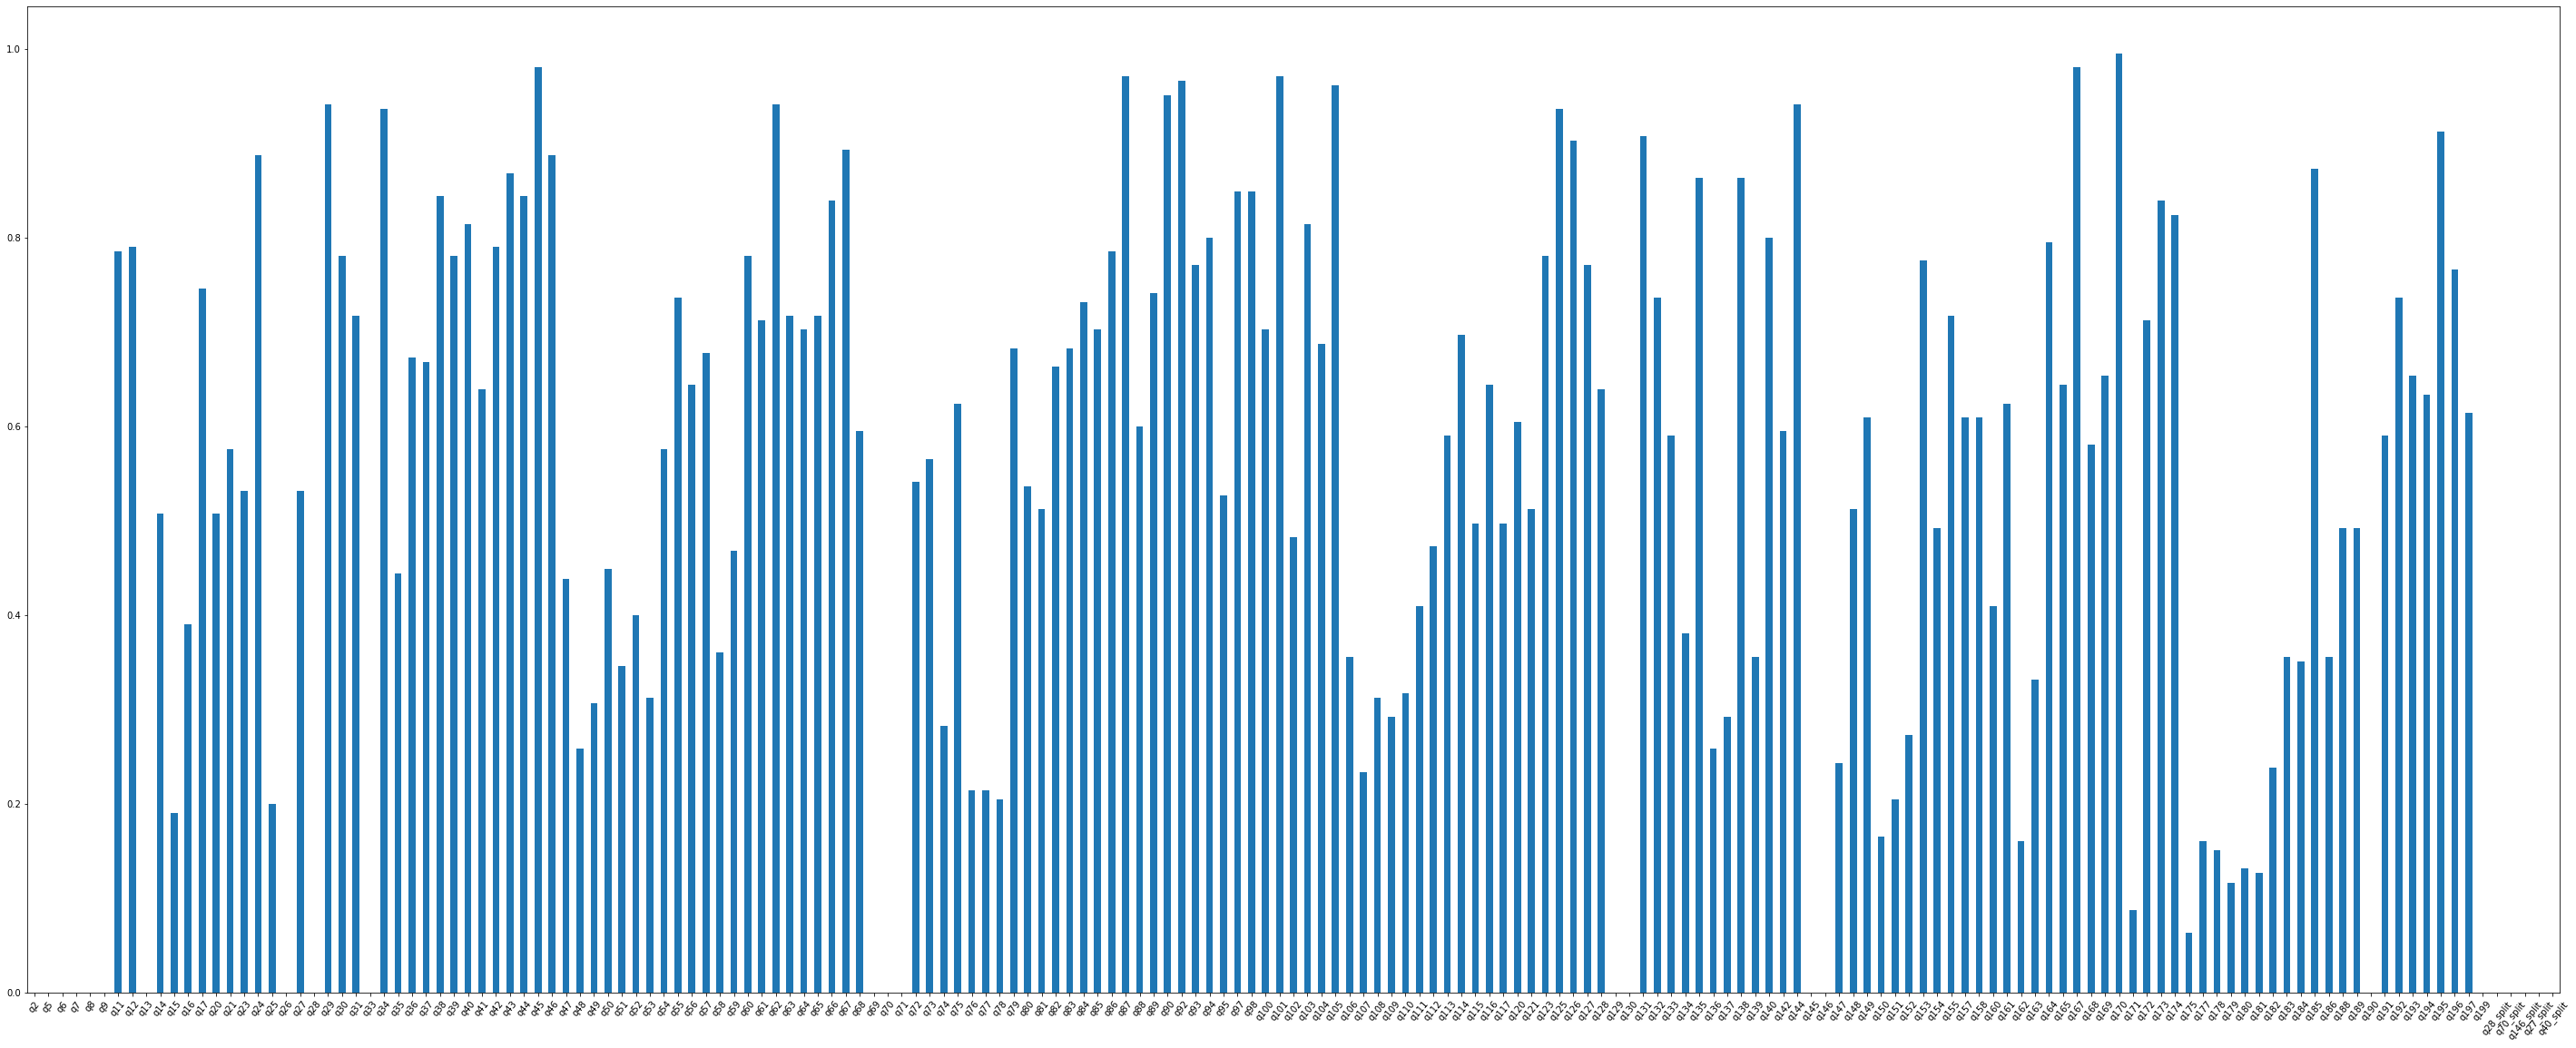

In [47]:
# visualize missingness

question_data_unlabeled = question_data.drop(columns=['id', 'nid'])
q_nullseries = question_data_unlabeled.isna().sum() / question_data_unlabeled.shape[0] # calculate % NaN per column
ax = q_nullseries.plot.bar(x='question', y='% missing', rot=50, figsize=(50,20)) # plot question vs. % missing

In [48]:
# collapse rows with the same ID by picking the one with the least missingness

for i in question_data.id.unique(): # for each unique id...
    temp = question_data[question_data.id == i].copy() # extract rows with corresponding id
    if temp.shape[0] > 1: # if there is more than one entry...
        idx = temp.isna().sum(axis=1).idxmin() # get the id of the row with min missing
        idxs = list(temp.index.values)
        idxs.remove(idx)
        question_data.drop(index=idxs, inplace=True)
        
question_data.shape

(123, 183)

In [49]:
# drop columns with a higher % missing than our threshold

cols_to_drop = []
    
for ind,val in q_nullseries.iteritems():
    if val > missingness_threshold:
        cols_to_drop.append(ind)

question_data.drop(columns=cols_to_drop, inplace=True)
question_data.shape

(123, 136)

In [50]:
outcomes = pd.read_stata('./data/test.dta') # read outcome data
print(outcomes.shape)
outcomes.head()

(123, 372)


,ptid,center_ptid,var3,trr_id_code,sex,age,race,primarylanguage,insurance,drinksperday,yrsheavydrink,marital,psych,psychmed,smoke1illicit2,smoker,thc,rehab,famhx,job,legalhx,var22,var23,lastdrink,initial_hospdate,center_hospdate,listdate,ltdate,dischargedate,lastcontact,death,jaundice,jaundicedate,heavydrink,contributingcause,var36,therapy,therapyduration,steroid_whynot,lille_steroid,lille_nosteroid,osh_lab_date,sodium_osh,inr_osh,bili_osh,cr_osh,rrt_osh,meld_osh,maddrey_osh,var51,hosp_lab_date,sodium_hosp,inr_hosp,pt_hosp,pt_control,bili_hosp,cr_hosp,rrt_hosp,meld_hosp,maddrey_hosp,wbc,ast,alt,hcv,hbv,albumin,bun_hosp,map_hosp,vasopressor_hosp,pao2ratio_hosp,spo2ratio_hosp,list_lab_date,na_list,inr_list,bili_list,cr_list,rrt_list,meld_list,var80,lt_lab_date,na_lt,inr_lt,bili_lt,cr_lt,rrt_lt,meld_lt,pvt,albumin_lt,bun_lt,map_lt,vasopressor_lt,pao2ratio_lt,spo2_ratio,bmi,var96,vent,gib,ascites,encephalopathy,var101,var102,sepsis,sepsis_type,sepsis_pathogen,sepsis_site,pancreatitis,gib_ah,var109,inf,var111,vascular,biliary,rejection,var115,alc_postlt,alc_diag,binge_alc,freq_alc,stilldrinking,alc_postlt_date,othercomplications,var123,biopsy_recurrent,graftfailure,chronicrejection,prelt_biopsy,var128,var129,var130,var131,var132,var133,center,event,otherid,race_txt,primarylanguage_txt,psych_txt,psychmed_txt,illicit_txt,death_txt,contributingcause_txt,steroid,pentoxifylline,nac,steroid_days,pentoxifylline_days,nac_days,steroid_whynot_txt,vasopressor_hosp_txt,vasopressor_lt_txt,sepsis_date,sepsis_txt,pancreatitis_date,gib_ah_date,gib_ah_txt,inf1_type,inf1_date,inf1_pathogen,inf1_site,inf1_txt,inf2_type,inf2_date,inf2_pathogen,inf2_site,inf2_txt,vascular_date,vascular_txt,biliary_date,biliary_txt,rejection_date,rejection_txt,alc_diagtxt,biopsy_recurrent_date,prelt_biopsy_txt,graftfailure_txt,chronicrejection_txt,var48,var49,lt_date_update,hospdays,postlt_rrt,lost,fu_date_update,death_update,cod_txt,cod_alcohol,death_date_update,postlt_ah,lost_compliance,lost_transition,lost_txt,hospdeath,lastdrink_destring,initial_hospdate_destring,center_hospdate_destring,listdate_destring,ltdate_destring,dischargedate_destring,lastcontact_destring,osh_lab_date_destring,hosp_lab_date_destring,list_lab_date_destring,lt_lab_date_destring,alc_postlt_date_destring,rejection_date_destring,fu_time,fu_time_yrs,death_time,death_time_yrs,abstime,abstime_yrs,hosptime,alc_postlt_interval,alc_postlt_interval_yrs,rejection_time,rejection_time_yrs,caucasian,private,medicaid,medicare,tendrinksperday,fifteenyrsheavydrink,illicit,anyrehab,multiplerehab,anylegalhx,multiplelegalhx,anymarital,anyfamhx,overtencephalopathy,fu_sincelastdrink,sustained_alc,slip,harmfuldrink,ordinaldrink,event_date,event_type,event_hosp,event_hospdate,event_drinksperday,event_drinkingdaysperweek,event_meld,event_ascites,event_overtencephalopathy,event_varicealbleeding,event_jaundice,event_sobriety,event_relapse,event_niaaa_jaundice,event_jaundicedate,event_niaaa_heavy,event_niaaa_contributing,event_niaaa_ast,event_niaaa_ratio,event_biopsy,var24,var25,event_hosp1_date,event_hosp1_reason,event_hosp2_date,event_hosp2_reason,event_hosp3_date,event_hosp3_reason,event_hosp4_date,event_hosp4_reason,event_hosp5_date,event_hosp5_reason,var38,var39,event_withdrawal,event_withdrawal_date,event_pancreatitis,event_pancreatitis_date,event_seizure,event_seizure_date,var46,event_aa,event_aa_date,event_outpatientrehab,event_outpatientrehab_date,event_inpatientrehab,event_inpatientrehab_date,event_med_date,var54,var55,var56,event_factor_txt,event_factor_young,event_factor_children,event_factor_social,event_factor_advocate,event_factor_other,var63,event_contributing_txt,event_biopsy_txt,event_type_txt,var37,var43,var52,var73,var81,var122,var127,explant_txt,nid,id,psychiatrist,counselor,socialworker,narrcount,q2,q25,q26,q27,q28,q29,q30,q31,q34,q99,q123,q124,q125,q126,q127,q144,q146,writer_com,language_com,behavior_com,hpi_com,consistency_com,medhis_com,adherence_com,mental_com,alcohol_com,insight_com,education_

In [51]:
outcomes = outcomes[[outcome,'center','ptid','hospdeath','sex','age']]
outcomes.head()

,harmfuldrink,center,ptid,hospdeath,sex,age
0,0.0,1,1.0,0.0,1,44
1,0.0,1,2.0,0.0,0,62
2,0.0,1,3.0,0.0,1,52
3,1.0,1,4.0,0.0,1,44
4,0.0,1,5.0,0.0,1,58


In [52]:
combined = outcomes.merge(question_data, left_on='ptid', right_on='id', how='left') # merge with question data
print(combined.shape)
combined.head()

(123, 142)


,harmfuldrink,center,ptid,hospdeath,sex,age,q2,q5,q6,q7,q8,q9,q13,q14,q15,q16,q17,q20,q21,q23,q25,q26,q27,q28,q31,q33,q35,q36,q37,q41,q47,q48,q49,q50,q51,q52,q53,q54,q55,q56,q57,q58,q59,q61,q63,q64,q65,q68,q69,q70,q71,q72,q73,q74,q75,q76,q77,q78,q79,q80,q81,q82,q83,q84,q85,q88,q89,q95,q100,q102,q104,q106,q107,q108,q109,q110,q111,q112,q113,q114,q115,q116,q117,q120,q121,q128,q129,q130,q132,q133,q134,q136,q137,q139,q142,q145,q146,q147,q148,q149,q150,q151,q152,q154,q155,q157,q158,q160,q161,q162,q163,q165,q168,q169,q171,q172,q175,q177,q178,q179,q180,q181,q182,q183,q184,q186,q188,q189,q190,q191,q192,q193,q194,q197,q199,id,nid,q28_split,q70_split,q146_split,q27_split,q40_split
0,0.0,1,1.0,0.0,1,44,2,1,0,0,0,0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,0,NaN,0,0.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,36.0,8.0,8.0,0.0,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0,0,NaN,NaN,0.0,1.0,NaN,1.0,NaN,0,1,4.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,0.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,1,1.0,NaN,0.0,NaN,2.0,0,1,47,0,0,1,0,0
1,0.0,1,2.0,0.0,0,62,2,1,0,0,0,0,1,NaN,0.0,2.0,NaN,NaN,NaN,NaN,0.0,0,NaN,0,NaN,0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0,0,0,NaN,60.0,NaN,2.0,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,0,1.0,1.0,0.0,NaN,NaN,NaN,2.0,0,0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1,1.0,NaN,NaN,1.0,NaN,0,2,48,0,0,0,0,0
2,0.0,1,3.0,0.0,1,52,2,1,0,0,0,0,1,NaN,0.0,2.0,NaN,0.0,0.0,NaN,0.0,0,NaN,2,0.0,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,7.0,8.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,0,NaN,NaN,0.0,1.0,1.0,1.0,2.0,0,0,5.0,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,0,3,49,1,0,0,0,0
3,1.0,1,4.0,0.0,1,44,2,1,0,0,0,0,1,1.0,1.0,2.0,NaN,0.0,0.0,1.0,0.0,0,NaN,2,NaN,0,0.0,0.0,2.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,1,0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2.0,NaN,0.0,0.0,0.0,NaN,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,1,1.0,NaN,NaN,1.0,NaN,0,4,81,1,0,0,0,0
4,0.0,1,5.0,0.0,1,58,2,1,0,0,0,1,1,1.0,0.0,2.0,NaN,0.0,NaN,NaN,0.0,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,18.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,0.0,NaN,1.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,0,3,5.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1,1.0,NaN,0.0,NaN,2.0,0,5,82,0,0,1,0,0


In [53]:
combined = combined[combined.hospdeath != 1] # remove patients who died in the hospital
combined.drop(columns=['hospdeath'], inplace=True)
combined.shape

(116, 141)

In [54]:
# one-hot encode categorical features

categorical_vars = ['q2','q12','q13','q21','q24','q71','q128','q160','q190']

for c_v in categorical_vars:
    if c_v in list(combined.columns):
        # one-hot encode variable
        one_hot = pd.get_dummies(combined[c_v], prefix=c_v, dummy_na=True)
        combined = combined.drop(c_v, axis = 1)
        combined = combined.join(one_hot)

print(combined.shape)
combined.head()

(116, 161)


,harmfuldrink,center,ptid,sex,age,q5,q6,q7,q8,q9,q14,q15,q16,q17,q20,q23,q25,q26,q27,q28,q31,q33,q35,q36,q37,q41,q47,q48,q49,q50,q51,q52,q53,q54,q55,q56,q57,q58,q59,q61,q63,q64,q65,q68,q69,q70,q72,q73,q74,q75,q76,q77,q78,q79,q80,q81,q82,q83,q84,q85,q88,q89,q95,q100,q102,q104,q106,q107,q108,q109,q110,q111,q112,q113,q114,q115,q116,q117,q120,q121,q129,q130,q132,q133,q134,q136,q137,q139,q142,q145,q146,q147,q148,q149,q150,q151,q152,q154,q155,q157,q158,q161,q162,q163,q165,q168,q169,q171,q172,q175,q177,q178,q179,q180,q181,q182,q183,q184,q186,q188,q189,q191,q192,q193,q194,q197,q199,id,nid,q28_split,q70_split,q146_split,q27_split,q40_split,q2_0.0,q2_1.0,q2_2.0,q2_nan,q13_0.0,q13_1.0,q13_2.0,q13_nan,q21_0.0,q21_1.0,q21_2.0,q21_nan,q71_0.0,q71_2.0,q71_nan,q128_0.0,q128_1.0,q128_2.0,q128_nan,q160_0.0,q160_1.0,q160_2.0,q160_nan,q190_0.0,q190_1.0,q190_2.0,q190_nan
0,0.0,1,1.0,1,44,1,0,0,0,0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0,NaN,0,NaN,0,0.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,36.0,8.0,8.0,0.0,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,0,NaN,NaN,0.0,1.0,NaN,1.0,NaN,0,1,4.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN,2.0,0,1,47,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
1,0.0,1,2.0,0,62,1,0,0,0,0,NaN,0.0,2.0,NaN,NaN,NaN,0.0,0,NaN,0,NaN,0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0,0,NaN,60.0,NaN,2.0,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,1.0,0.0,NaN,NaN,NaN,2.0,0,0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,0,2,48,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,0.0,1,3.0,1,52,1,0,0,0,0,NaN,0.0,2.0,NaN,0.0,NaN,0.0,0,NaN,2,0.0,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,7.0,8.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN,NaN,0.0,1.0,1.0,1.0,2.0,0,0,5.0,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,0,3,49,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
3,1.0,1,4.0,1,44,1,0,0,0,0,1.0,1.0,2.0,NaN,0.0,1.0,0.0,0,NaN,2,NaN,0,0.0,0.0,2.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,NaN,0,0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,1,0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,0,4,81,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
4,0.0,1,5.0,1,58,1,0,0,0,1,1.0,0.0,2.0,NaN,0.0,NaN,0.0,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,18.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,0.0,NaN,1.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,0,3,5.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,2.0,0,5,82,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0


In [55]:
combined[outcome].value_counts() / combined.shape[0] # outcome distribution

0.0    0.706897
1.0    0.293103
Name: harmfuldrink, dtype: float64

In [56]:
combined[outcome].value_counts()

0.0    82
1.0    34
Name: harmfuldrink, dtype: int64

In [57]:
combined[outcome].isna().sum() # verify no missing outcome variables

0

In [58]:
# combined[outcome].fillna(0, inplace=True) # replace missing outcome with 0 meaning no harmful drinking
combined.drop(inplace=True, columns=['id', 'ptid', 'nid']) # remove merging variables
print(combined.shape)
combined.head()

(116, 158)


,harmfuldrink,center,sex,age,q5,q6,q7,q8,q9,q14,q15,q16,q17,q20,q23,q25,q26,q27,q28,q31,q33,q35,q36,q37,q41,q47,q48,q49,q50,q51,q52,q53,q54,q55,q56,q57,q58,q59,q61,q63,q64,q65,q68,q69,q70,q72,q73,q74,q75,q76,q77,q78,q79,q80,q81,q82,q83,q84,q85,q88,q89,q95,q100,q102,q104,q106,q107,q108,q109,q110,q111,q112,q113,q114,q115,q116,q117,q120,q121,q129,q130,q132,q133,q134,q136,q137,q139,q142,q145,q146,q147,q148,q149,q150,q151,q152,q154,q155,q157,q158,q161,q162,q163,q165,q168,q169,q171,q172,q175,q177,q178,q179,q180,q181,q182,q183,q184,q186,q188,q189,q191,q192,q193,q194,q197,q199,q28_split,q70_split,q146_split,q27_split,q40_split,q2_0.0,q2_1.0,q2_2.0,q2_nan,q13_0.0,q13_1.0,q13_2.0,q13_nan,q21_0.0,q21_1.0,q21_2.0,q21_nan,q71_0.0,q71_2.0,q71_nan,q128_0.0,q128_1.0,q128_2.0,q128_nan,q160_0.0,q160_1.0,q160_2.0,q160_nan,q190_0.0,q190_1.0,q190_2.0,q190_nan
0,0.0,1,1,44,1,0,0,0,0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0,NaN,0,NaN,0,0.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,36.0,8.0,8.0,0.0,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,0,NaN,NaN,0.0,1.0,NaN,1.0,NaN,0,1,4.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN,2.0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
1,0.0,1,0,62,1,0,0,0,0,NaN,0.0,2.0,NaN,NaN,NaN,0.0,0,NaN,0,NaN,0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0,0,NaN,60.0,NaN,2.0,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,1.0,0.0,NaN,NaN,NaN,2.0,0,0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,0.0,1,1,52,1,0,0,0,0,NaN,0.0,2.0,NaN,0.0,NaN,0.0,0,NaN,2,0.0,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,7.0,8.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN,NaN,0.0,1.0,1.0,1.0,2.0,0,0,5.0,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
3,1.0,1,1,44,1,0,0,0,0,1.0,1.0,2.0,NaN,0.0,1.0,0.0,0,NaN,2,NaN,0,0.0,0.0,2.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,NaN,0,0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,1,0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
4,0.0,1,1,58,1,0,0,0,1,1.0,0.0,2.0,NaN,0.0,NaN,0.0,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,18.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,0.0,NaN,1.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,0,3,5.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,2.0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0


In [59]:
combined.to_csv('./data/data_final.csv') # checkpoint data

In [60]:
if len(validation_centers) != 0:
    if validation_centers[0] == 'rand':
        if validation_centers[2] == 'one-hot':
            # one-hot encode center variable
            one_hot = pd.get_dummies(combined['center'], prefix='center')
            combined = combined.drop('center', axis=1)
            combined = combined.join(one_hot)
        elif validation_centers[2] == 'drop':
            combined.drop(columns=['center'], inplace=True) # drop center variable
        
        train, val = train_test_split(combined, test_size=validation_centers[1], random_state=s) # reserve a percentage of rows randomly
    else:
        val = combined.loc[combined['center'].isin(validation_centers)] # reserve validation centers from list
        train = combined.loc[~combined['center'].isin(validation_centers)] # remove centers from list
        
        val.drop(columns=['center'], inplace=True)
        train.drop(columns=['center'], inplace=True)
        
    val_X = val.drop(columns=[outcome]) # extract predictors
    val_y = val[outcome] # extract outcome
    print(val_X.shape, val_y.shape)
else:
    train = combined.copy()

(27, 156) (27,)


/Users/prathikr/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [61]:
if len(validation_centers) != 0:
    print(val_y.value_counts())

0.0    19
1.0     8
Name: harmfuldrink, dtype: int64


In [62]:
train.head() # see if one-hot encoding or dropping of center worked

,harmfuldrink,sex,age,q5,q6,q7,q8,q9,q14,q15,q16,q17,q20,q23,q25,q26,q27,q28,q31,q33,q35,q36,q37,q41,q47,q48,q49,q50,q51,q52,q53,q54,q55,q56,q57,q58,q59,q61,q63,q64,q65,q68,q69,q70,q72,q73,q74,q75,q76,q77,q78,q79,q80,q81,q82,q83,q84,q85,q88,q89,q95,q100,q102,q104,q106,q107,q108,q109,q110,q111,q112,q113,q114,q115,q116,q117,q120,q121,q129,q130,q132,q133,q134,q136,q137,q139,q142,q145,q146,q147,q148,q149,q150,q151,q152,q154,q155,q157,q158,q161,q162,q163,q165,q168,q169,q171,q172,q175,q177,q178,q179,q180,q181,q182,q183,q184,q186,q188,q189,q191,q192,q193,q194,q197,q199,q28_split,q70_split,q146_split,q27_split,q40_split,q2_0.0,q2_1.0,q2_2.0,q2_nan,q13_0.0,q13_1.0,q13_2.0,q13_nan,q21_0.0,q21_1.0,q21_2.0,q21_nan,q71_0.0,q71_2.0,q71_nan,q128_0.0,q128_1.0,q128_2.0,q128_nan,q160_0.0,q160_1.0,q160_2.0,q160_nan,q190_0.0,q190_1.0,q190_2.0,q190_nan
0,0.0,1,44,1,0,0,0,0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0,NaN,0,NaN,0,0.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,36.0,8.0,8.0,0.0,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,0,NaN,NaN,0.0,1.0,NaN,1.0,NaN,0,1,4.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN,2.0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
1,0.0,0,62,1,0,0,0,0,NaN,0.0,2.0,NaN,NaN,NaN,0.0,0,NaN,0,NaN,0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0,0,NaN,60.0,NaN,2.0,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,1.0,0.0,NaN,NaN,NaN,2.0,0,0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,0.0,1,52,1,0,0,0,0,NaN,0.0,2.0,NaN,0.0,NaN,0.0,0,NaN,2,0.0,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,7.0,8.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN,NaN,0.0,1.0,1.0,1.0,2.0,0,0,5.0,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
3,1.0,1,44,1,0,0,0,0,1.0,1.0,2.0,NaN,0.0,1.0,0.0,0,NaN,2,NaN,0,0.0,0.0,2.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,NaN,0,0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,1,0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
4,0.0,1,58,1,0,0,0,1,1.0,0.0,2.0,NaN,0.0,NaN,0.0,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,18.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,0.0,NaN,1.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,0,3,5.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,2.0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0


In [63]:
# upsample minority class ***in training data only*** to combat outcome class imbalance and small dataset

if include_upsampling:
    print('Training set outcome counts:\n', train[outcome].value_counts().to_frame())
    negative = train[train[outcome] == 0] # separate majority...
    positive = train[train[outcome] == 1] # ...and minority class

    # upsample minority
    pos_upsampled = resample(positive, 
                               replace=True, # sample with replacement
                               n_samples=len(negative)) # match number in majority class

    # combine majority and upsampled minority
    upsampled = pd.concat([negative, pos_upsampled])
    X = upsampled.drop(columns=[outcome])
    y = upsampled[outcome]

    print('Upsampled dataset sizes', X.shape, y.shape)
    print('Upsampled training set outcome counts:\n', y.value_counts().to_frame())
else:
    X = train.drop(columns=[outcome]) # extract predictors
    y = train[outcome] # extract outcome
    print(X.shape, y.shape)

(89, 156) (89,)


In [64]:
X.isna().sum().sum()

4180

In [65]:
# impute missing data

if imputation_strategy == '-1':
    X.fillna(-1, inplace=True) # replace NaN with -1 to signify ommitted question
elif imputation_strategy == 'mode':
    for col in X.columns:
        X[col].fillna(X[col].mode()[0], inplace=True)

In [66]:
X.isna().sum().sum()

4180

## Modelling



Optimal number of features: 9


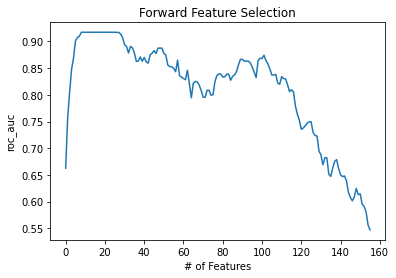

In [67]:
def forward_feature_selection(model, X, y):
    features = list(X.columns)
    selected_features = []
    scores = []
    
    for i in tqdm(range(X.shape[1])):
        best_score = 0
        next_feat = ''
        for feat in features:
            selected_features.append(feat)
            temp_X = X[selected_features]
            if optimization_metric == 'precision':
                scorer = make_scorer(metrics.precision_score, zero_division=1)
            else:
                scorer = [optimization_metric] # for some reason only works when in an array...
            temp_scores = cross_validate(clone(model), temp_X, y, cv=5, scoring=scorer)
            if optimization_metric == 'precision':
                label = 'test_score'
            else:
                label = 'test_' + optimization_metric # since in array, won't be test_score
            temp_score = temp_scores[label].mean()
            if temp_score >= best_score:
                best_score = temp_score
                next_feat = feat
            selected_features.pop()
        #print('Added Feature:', next_feat)
        selected_features.append(next_feat)
        features.remove(next_feat)
        scores.append(best_score)
        
    #print('Ordering of Features:', selected_features)
    
    plt.title('Forward Feature Selection')
    plt.xlabel('# of Features')
    plt.ylabel(optimization_metric)
    plt.plot(list(range(X.shape[1])), scores)
    return scores, selected_features

if include_feature_selection:
    scores, selected_features = forward_feature_selection(model, X, y)
    optimal_n_features = scores.index(max(scores)) + 1
    print('\nOptimal number of features:', optimal_n_features)
    optimal_features = selected_features[:optimal_n_features]
    X = X[optimal_features]
    if len(validation_centers) != 0:
        val_X = val_X[optimal_features]

In [68]:
# get value counts for our selected features for qualitative analysis

nullseries = X.isna().sum() / X.shape[0] # calculate % NaN per column of selected features
for feat in X.columns:
    print('--' + feat + '--')
    try:
        print('NaN ', nullseries[feat])
    except KeyError: # center variable not in q_nullseries, default to 0 missing values
        print('NaN  0')
    print(X[feat].value_counts() / X.shape[0]) 

--q133--
NaN  0.48314606741573035
1.0    0.494382
0.0    0.022472
Name: q133, dtype: float64
--q177--
NaN  0.10112359550561797
0.0    0.752809
1.0    0.146067
Name: q177, dtype: float64
--q149--
NaN  0.6067415730337079
0.0    0.337079
1.0    0.056180
Name: q149, dtype: float64
--q188--
NaN  0.43820224719101125
1.0    0.516854
0.0    0.044944
Name: q188, dtype: float64
--q155--
NaN  0.6067415730337079
0.0    0.269663
1.0    0.123596
Name: q155, dtype: float64
--q136--
NaN  0.29213483146067415
1.0    0.707865
Name: q136, dtype: float64
--q148--
NaN  0.5955056179775281
0.0    0.325843
1.0    0.078652
Name: q148, dtype: float64
--q25--
NaN  0.19101123595505617
0.0    0.719101
1.0    0.078652
2.0    0.011236
Name: q25, dtype: float64
--q2_1.0--
NaN  0.0
0    0.707865
1    0.292135
Name: q2_1.0, dtype: float64


In [69]:
# evaluate training performance of feature optimized model across folds and calculate confidence intervals

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    npv = tn / (tn + fn)
    return npv

precision_scorer = make_scorer(metrics.precision_score, zero_division=1)
npv_scorer = make_scorer(npv_score)

scoring_dict = {'accuracy': 'accuracy', 'precision': precision_scorer, 'npv': npv_scorer, 'recall': 'recall', 'roc_auc': 'roc_auc'}

scores = cross_validate(clone(model), X, y, cv=5, scoring=scoring_dict, return_estimator=True)

confidence_level = 2.776 # corresponding z-score value for 95% confidence and 4 degrees of freedom (since we did 5 fold cv)
print('Accuracy:', round(scores['test_accuracy'].mean(), 4), "+/-", round(confidence_level * scores['test_accuracy'].std() / sqrt(len(scores['test_accuracy'])), 4))
print('Precision/PPV:', round(scores['test_precision'].mean(), 4), "+/-", round(confidence_level * scores['test_precision'].std() / sqrt(len(scores['test_precision'])), 4))
print('NPV:', round(scores['test_npv'].mean(), 4), "+/-", round(confidence_level * scores['test_npv'].std() / sqrt(len(scores['test_npv'])), 4))
print('Recall:', round(scores['test_recall'].mean(), 4), "+/-", round(confidence_level * scores['test_recall'].std() / sqrt(len(scores['test_recall'])), 4))
print('AUC:', round(scores['test_roc_auc'].mean(), 4), "+/-", round(confidence_level * scores['test_roc_auc'].std() / sqrt(len(scores['test_roc_auc'])), 4))

Accuracy: 0.8203 +/- 0.1102
Precision/PPV: 0.8124 +/- 0.2594
NPV: 0.8554 +/- 0.0917
Recall: 0.6133 +/- 0.274
AUC: 0.9172 +/- 0.1204


In [70]:
# have all models predict on validation center and get mean performance metrics and confidence intervals

if len(validation_centers) != 0:
    accuracy_scores = np.array([])
    precision_scores = np.array([])
    npv_scores = np.array([])
    recall_scores = np.array([])
    roc_auc_scores = np.array([])

    for model in scores['estimator']:
        val_y_pred = model.predict(val_X)
        accuracy_scores = np.append(accuracy_scores, metrics.accuracy_score(val_y, val_y_pred))
        precision_scores = np.append(precision_scores, metrics.precision_score(val_y, val_y_pred, zero_division=1))
        npv_scores = np.append(npv_scores, npv_score(val_y, val_y_pred))
        recall_scores = np.append(recall_scores, metrics.recall_score(val_y, val_y_pred))
        roc_auc_scores = np.append(roc_auc_scores, metrics.roc_auc_score(val_y, val_y_pred))
        
    confidence_level = 2.776 # corresponding z-score value for 95% confidence and 4 degrees of freedom (since we did 5 fold cv)
    print('Accuracy:', round(accuracy_scores.mean(), 4), "+/-", round(confidence_level * accuracy_scores.std() / sqrt(len(accuracy_scores)), 4))
    print('Precision/PPV:', round(precision_scores.mean(), 4), "+/-", round(confidence_level * precision_scores.std() / sqrt(len(precision_scores)), 4))
    print('NPV:', round(npv_scores.mean(), 4), "+/-", round(confidence_level * npv_scores.std() / sqrt(len(npv_scores)), 4))
    print('Recall:', round(recall_scores.mean(), 4), "+/-", round(confidence_level * recall_scores.std() / sqrt(len(recall_scores)), 4))
    print('AUC:', round(roc_auc_scores.mean(), 4), "+/-", round(confidence_level * roc_auc_scores.std() / sqrt(len(roc_auc_scores)), 4))

Accuracy: 0.5481 +/- 0.0451
Precision/PPV: 0.2667 +/- 0.057
NPV: 0.6887 +/- 0.0314
Recall: 0.3 +/- 0.076
AUC: 0.4763 +/- 0.0483


## Post-Processing

In [71]:
# collect feature importance values across training folds

d = {'q': X.columns} # create feature importance dataframe
col_headers = []

idx = 1
for model in scores['estimator']:
    col_header = 'feat_imp_fold' + str(idx)
    d[col_header] = model.feature_importances_
    col_headers.append(col_header)
    idx += 1
    
feat_imp = pd.DataFrame(data=d)

feat_imp['feat_imp_mean'] = feat_imp[col_headers].mean(axis=1)
feat_imp['feat_imp_std'] = feat_imp[col_headers].std(axis=1)
feat_imp['feat_imp_zeros'] = (feat_imp[col_headers] == 0).astype(int).sum(axis=1)
feat_imp['feat_imp_95_ci'] = confidence_level * feat_imp['feat_imp_std'] / sqrt(len(col_headers))

feat_imp.head()

,q,feat_imp_fold1,feat_imp_fold2,feat_imp_fold3,feat_imp_fold4,feat_imp_fold5,feat_imp_mean,feat_imp_std,feat_imp_zeros,feat_imp_95_ci
0,q133,0.093365,0.101682,0.093510,0.117716,0.115432,0.104341,0.011691,0,0.014514
1,q177,0.109095,0.296618,0.232098,0.140966,0.147969,0.185349,0.077052,0,0.095657
2,q149,0.136747,0.050859,0.164406,0.102249,0.104457,0.111744,0.042570,0,0.052849
3,q188,0.118420,0.053128,0.069072,0.092663,0.096259,0.085909,0.025337,0,0.031455
4,q155,0.143428,0.202291,0.125194,0.213823,0.168975,0.170742,0.037667,0,0.046762


In [72]:
feat_imp.drop(columns=col_headers, inplace=True) # drop intermediary scores
feat_imp.sort_values(by='feat_imp_mean', ascending=False, inplace=True) # sort by mean feature importance
feat_imp = feat_imp.merge(nullseries.rename('% NaN').to_frame(),left_index=False,left_on='q',right_index=True) # merge % missing with feature importances
feat_imp.head()

,q,feat_imp_mean,feat_imp_std,feat_imp_zeros,feat_imp_95_ci,% NaN
1,q177,0.185349,0.077052,0,0.095657,0.101124
4,q155,0.170742,0.037667,0,0.046762,0.606742
8,q2_1.0,0.121465,0.031688,0,0.039340,0.000000
2,q149,0.111744,0.042570,0,0.052849,0.606742
0,q133,0.104341,0.011691,0,0.014514,0.483146


In [73]:
# convert questions from "q{XXX}" format to full English question

def question_decoder(question_code):
    if '_' in question_code:
        question_code = question_code.split('_')[0] # get text before the underscore
    question_code = question_code.upper()
    
    df = pd.read_excel('./data/Psychosocial data dictionary.xlsx', index_col=0)
    questions = df['QUESTIONS']
    try:
        return questions[question_code]
    except KeyError:
        return None

feat_imp['q_decoded'] = feat_imp['q'].apply(lambda x: question_decoder(x))
feat_imp

,q,feat_imp_mean,feat_imp_std,feat_imp_zeros,feat_imp_95_ci,% NaN,q_decoded
1,q177,0.185349,0.077052,0,0.095657,0.101124,Are there any adult children or grandchildren (>=18 years old) who live with the patient?
4,q155,0.170742,0.037667,0,0.046762,0.606742,Is the patient observant for his or her religion and/or attend services regularly? (Enter 99 if not applicable.)
8,q2_1.0,0.121465,0.031688,0,0.039340,0.000000,What is the background/training of the writer?
2,q149,0.111744,0.042570,0,0.052849,0.606742,Was the patient recently a home caregiver for children or elderly relatives?
0,q133,0.104341,0.011691,0,0.014514,0.483146,Does the patient identify alcohol as the cause of his or her liver disease?
6,q148,0.095508,0.037028,0,0.045969,0.595506,Did the patient ever serve in the U.S. military?
3,q188,0.085909,0.025337,0,0.031455,0.438202,Does the patient currently have a healthy/strong relationship with his or her children? (Enter 99 if no living children.)
5,q136,0.080384,0.028320,0,0.035159,0.292135,Is the patient committed/motivated towards alcohol abstinence?
7,q25,0.044559,0.018653,0,0.023157,0.191011,How forthcomining was the patient with any negative information?


In [74]:
lasso_features = feat_imp[feat_imp['feat_imp_mean'] > 0]['q'].tolist() # get features that have >0 feature importance
lasso_data = X[lasso_features]
lasso_data.head()

,q177,q155,q2_1.0,q149,q133,q148,q188,q136,q25
0,0.0,NaN,0,NaN,NaN,NaN,NaN,1.0,0.0
1,0.0,NaN,0,0.0,1.0,NaN,1.0,NaN,0.0
2,0.0,NaN,0,NaN,NaN,NaN,NaN,1.0,0.0
3,0.0,NaN,0,0.0,NaN,NaN,NaN,1.0,0.0
4,0.0,NaN,0,0.0,1.0,NaN,NaN,1.0,0.0


## Don't be dumb...

In [75]:
# triggers a ctrl-s so that conversion to html will work properly

def save_notebook(file_path):
    start_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
    
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
        
save_notebook('mvp.ipynb')

<IPython.core.display.Javascript object>

In [76]:
now = datetime.now()
current_time = now.strftime("(%H:%M:%S)")
current_date = now.date().strftime("%b-%d")

filename = current_date + current_time + ".html"
print("saving results to " + filename)
os.system("ipython nbconvert --to html mvp.ipynb")
os.rename('mvp.html', "./results_raw/" + filename)

saving results to May-16(19:25:15).html
